In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from utils.model import hill_activation, hill_activation_single, hill_activation_and, random_search
from utils.helper import setup_header, read_map, read_dict, generate_data, \
                         get_blank_corrected, get_neg_ctrl_corrected, get_pos_ctrl_corrected
from utils.plotter import plot_heatmap

In [2]:
folder = '100-promoters-characterization'
filename = '006-promoters-characterization-01'
plate_map = '006-plate_map'

sample_map = {
    'P62': 'pBAD-rJ/Ara',
    'P63': 'araC-pBAD-rJ/Ara',
    'P64': 'pCin-rJ/OHC14',
    'P65': 'pCymRC-rJ/Cuma',
    'P66': 'cymRC-pCymRC-rJ/Cuma',
    'P67': 'pLux2-rJ/AHL',
    'P68': 'pLuxB-rJ/AHL',
    'P69': 'pPhlF-rJ/DAPG',
    'P70': 'pSalTTC-rJ/Sal',
    'P71': 'pVanCC-rJ/Van',
    'P72': 'rhaS-pRhaB-rJ/Rha',
    'P73': 'araC-pBAD/Ara',
    'BK': 'blank-kan',
    'BA': 'blank-amp',
    'NK': 'negative-control-kan',
    'NA': 'negative-control-amp',
    'GFP': 'positive-control-amp'
}
inducers = []
promoters = ['pBAD-rJ/Ara', 'pCin-rJ/OHC14', 'cymRC-pCymRC-rJ/Cuma',
             'pLuxB-rJ/AHL', 'pPhlF-rJ/DAPG', 'pSalTTC-rJ/Sal', 'rhaS-pRhaB-rJ/Rha']

induction_lvl = 11
max_inducers = [416, 160, 800, 20, 50, 1600, 15300] #ara, ohc14, cuma, ahl, dapg, sal, rha
dil = 2
for x, mi in enumerate(max_inducers):
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

In [5]:
raw_data = setup_header(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, filename)))
sample_map = read_map(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, plate_map)))

group = 'A'
contents = ['Sample', 'Blank', 'Negative control'] #because blank and negative for group A were wrong
all_datas = []
for content in contents:
    datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                          sample_map, content, kind='1-input response function')
    all_datas.append(datas)

group = 'B'
contents = ['Positive control', 'Blank', 'Negative control']
all_ctrls = []
for content in contents:
    datas = generate_data(raw_data[(raw_data['Group']==group) & (raw_data['Content'].str.startswith(content))],
                          sample_map, content, kind='1-input response function')
    all_ctrls.append(datas)

In [6]:
fluo_idx, od_idx = 3, 0
rpu = True
h = 8
timepoint = 3 * h

if rpu:
    samples = get_pos_ctrl_corrected([all_datas[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                      all_datas[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]],
                                     [all_ctrls[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                      all_ctrls[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]])
else:
    samples = get_neg_ctrl_corrected([all_datas[0][fluo_idx], all_ctrls[1][fluo_idx], all_ctrls[2][fluo_idx],
                                      all_datas[0][od_idx], all_ctrls[1][od_idx], all_ctrls[2][od_idx]])
samples_t = samples.iloc[timepoint]

In [7]:
def plot_responses(data, promoters, inducers, row=2, col=2, xlabel='RPU', ylabel='RPU'):
    
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*6, row*3))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            ys = []
            for j in range(1, 3):
                label = '{}.{}'.format(promoters[i], j)
                y = data[filter(lambda x: x.startswith(label), samples_t.index)]
                if len(y)>0:
                    ys.append(y)
            ax.errorbar(inducers[i], np.mean(ys, axis=0), np.std(ys, axis=0), marker='o', linestyle='')
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            ax.loglog()
            ax.set_title(promoters[i])
        else:
            ax.set_visible(False)
    plt.tight_layout()
    sns.despine()

In [ ]:
def read_map(plate_map):
    
    plate_map = plate_map.melt(id_vars=['group'])
    plate_map['variable'] = plate_map['variable'].astype(int)
    plate_map['Well'] = plate_map['group'] + plate_map['variable'].apply(lambda x: '{:02d}'.format(x))
    plate_map.loc[~plate_map['group'].isin(['H']), 'suffix'] = (plate_map['variable'] - 1) % 12
    plate_map.loc[plate_map['group'].isin(['H']), 'suffix'] = (plate_map['variable'] - 1) % 2
    return plate_map[['Well', 'value', 'suffix']]

def generate_metadata(well, plate_map, sample_map):
    
    df = pd.merge(well, plate_map, on='Well', how='left').dropna(subset=['value']).reset_index(drop=True)
    df['short_name'] = df['value'].map(sample_map) + '_' + df['suffix'].astype(int).astype(str)
    return df.dropna()

def transpose_data(df, col, timepoint=20):
    
    df.set_index(col, inplace=True)
    df = df.transpose().reset_index(drop=True)
    df.index = df.index * timepoint
    return df

def generate_data(df, name, datapoint=2, num_data=4, start_idx=3, col='short_name'):
    
    datas = []
    idxs = [start_idx]
    for i in range(1, num_data+1):
        idxs.append(idxs[i-1] + datapoint)
        data = (df.iloc[:, idxs[i-1]:idxs[i]]).astype(float)
        data = pd.concat([name, data], axis=1)
        data = transpose_data(data, col)
        datas.append(data)
    return datas

def get_blank_corrected(data):
    
    blank_corrected = data.sub(data[filter(lambda x: x.startswith('blank'), data.columns)].mean(axis=1), axis=0)
    return blank_corrected.drop(filter(lambda x: x.startswith('blank'), blank_corrected.columns), axis=1).reset_index(drop=True)

def get_neg_ctrl_corrected(fluo, od):
    
    blank_corr_fluo = get_blank_corrected(fluo)
    blank_corr_od = get_blank_corrected(od)
    data = blank_corr_fluo / blank_corr_od
    neg_corrected = data.sub(data[filter(lambda x: x.startswith('negative-control'), data.columns)].mean(axis=1), axis=0)
    return neg_corrected.drop(filter(lambda x: x.startswith('negative-control'), neg_corrected.columns), axis=1)

In [ ]:
def generate_responses(data, promoters, inducers):
    
    df_res = pd.DataFrame([data[data.index.str.startswith(promoter)].values for promoter in promoters]).T
    df_res.columns = promoters
    df_ind = pd.DataFrame(inducers).T
    df_ind.columns = promoters
    return df_res, df_ind

def plot_responses(row, col, data, inducers, promoters, sharex=True, sharey=False, log_scale=False):
    
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*5, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = data[data.index.str.startswith(promoters[i])].values
            if log_scale:
                ax.scatter(np.log(inducers[i]), np.log(response))
            else:
                ax.scatter(inducers[i], response)
            ax.set_title('{}'.format(promoters[i]))
        else:
            ax.set_visible(False)
    
    sns.despine()
    plt.tight_layout()

In [40]:
def read_data(folder, filename, plate_map):
    
    plate_map = read_map(pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, plate_map)))
    raw_data = pd.read_csv('datasets/experiment/{}/{}.csv'.format(folder, filename), skiprows=[0])
    metadata = generate_metadata(raw_data['Well'], plate_map, sample_map)
    data = raw_data[raw_data['Well'].isin(metadata['Well'])].reset_index(drop=True)
    return generate_data(data, metadata['short_name'], datapoint=int((raw_data.shape[1] - 3)/4))

def get_data_at(fluos, ods, h=6):
    
    samples = get_neg_ctrl_corrected(fluos[filter(lambda x: '-amp' not in x, fluos.columns)],
                                 ods[filter(lambda x: '-amp' not in x, ods.columns)])
    reporter = get_neg_ctrl_corrected(fluos[filter(lambda x: '-amp' in x, fluos.columns)],
                                      ods[filter(lambda x: '-amp' in x, ods.columns)])
    return samples.iloc[int(h * 60/20)].apply(lambda x:  x / reporter.iloc[int(h * 60/20)].mean())

### 006

In [79]:
folder = '106-promoters-characterization'
filename = '006-promoters-characterization-01'
map_name = '006-plate_map'

promoters = ['pBAD-rJ/Ara', 'pCin-rJ/OHC14', 'cymRC-pCymRC-rJ/Cuma',
             'pLuxB-rJ/AHL', 'pPhlF-rJ/DAPG', 'pSalTTC-rJ/Sal', 'rhaS-pRhaB-rJ/Rha']

induction_lvl = 11
max_inducers = [416, 160, 800, 20, 50, 1600, 15300] #ara, ohc14, cuma, ahl, dapg, sal, rha
inducers = []
dil = 2
for x, mi in enumerate(max_inducers):
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

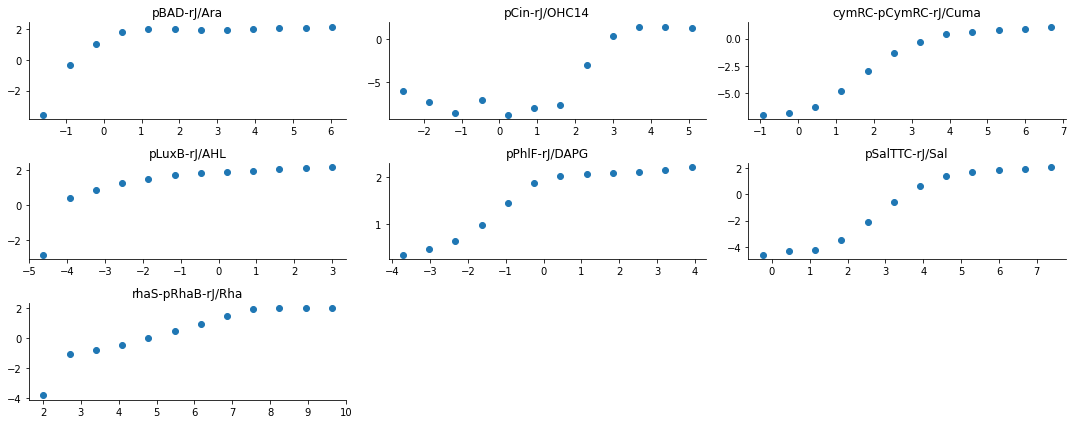

In [80]:
ods, fluos, fluos_1, fluos_2 = read_data(folder, filename, map_name)
df = get_data_at(fluos_2, ods, h=6)
df_res, df_ind = generate_responses(df, promoters, inducers)
plot_responses(3, 3, df, inducers, promoters, sharex=False, log_scale=True)

### 008

In [49]:
filename = '008-promoters-characterization-02'
map_name = '006-plate_map' #same plate map with experiment 006

promoters = ['pBAD-rJ/Ara', 'pCin-rJ/OHC14', 'cymRC-pCymRC-rJ/Cuma',
             'pLuxB-rJ/AHL', 'pPhlF-rJ/DAPG', 'pSalTTC-rJ/Sal', 'rhaS-pRhaB-rJ/Rha']

induction_lvl = 11
max_inducers = [416, 160, 800, 20, 50, 1600, 15300] #ara, ohc14, cuma, ahl, dapg, sal, rha
inducers = []
dil = 2
for x, mi in enumerate(max_inducers):
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl)]] + [0])
    inducer.reverse()
    inducers.append(inducer)

<ipython-input-47-cc6c2a6a502c>:17: RuntimeWarning: divide by zero encountered in log
  ax.scatter(np.log(inducers[i]), np.log(response))
<ipython-input-47-cc6c2a6a502c>:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.log(inducers[i]), np.log(response))


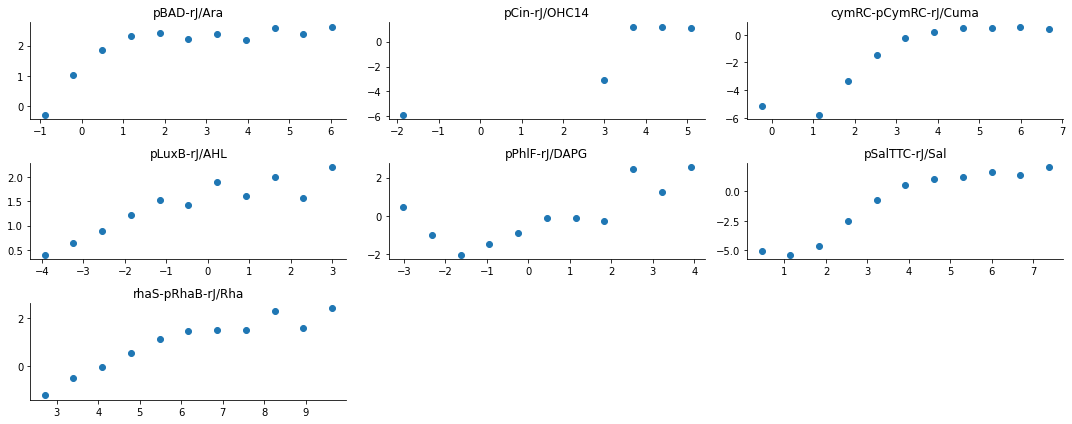

In [50]:
ods, fluos, fluos_1, fluos_2 = read_data(folder, filename, map_name)
df = get_data_at(fluos_2, ods, h=10)
df_res_2, df_ind_2 = generate_responses(df, promoters, inducers)
plot_responses(3, 3, df, inducers, promoters, sharex=False, log_scale=True)

In [74]:
filename = '010-promoters-characterization-03'
map_name = '006-plate_map' #same plate map with experiment 006

promoters = ['pBAD-rJ/Ara', 'pCin-rJ/OHC14', 'cymRC-pCymRC-rJ/Cuma',
             'pLuxB-rJ/AHL', 'pPhlF-rJ/DAPG', 'pSalTTC-rJ/Sal', 'rhaS-pRhaB-rJ/Rha']

induction_lvl = 11
max_inducers = [104, 320, 3200, 40, 50, 25600, 30600] #ara, ohc14, cuma, ahl, dapg, sal, rha
inducers = []
for x, mi in enumerate(max_inducers):
    dil = 4 if x==0 or x==3 else 2
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

<ipython-input-69-cc6c2a6a502c>:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.log(inducers[i]), np.log(response))


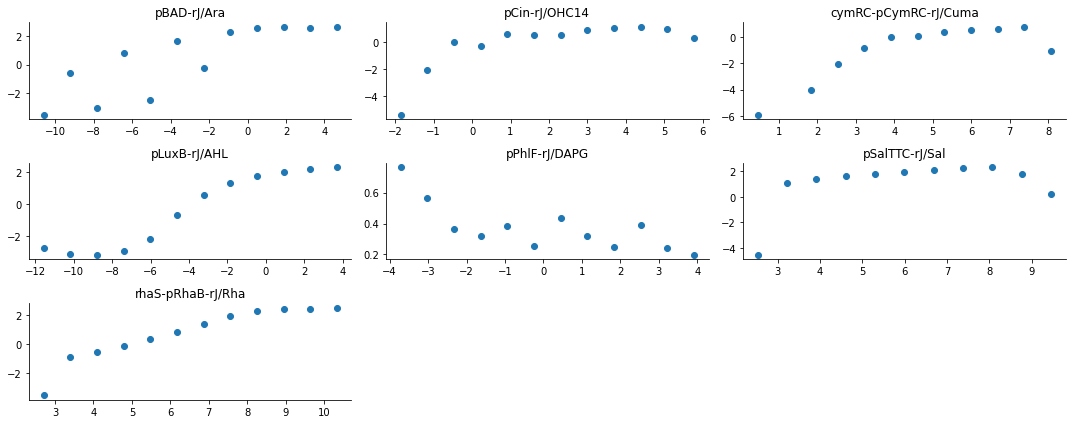

In [76]:
ods, fluos, fluos_1, fluos_2 = read_data(folder, filename, map_name)
df = get_data_at(fluos_2, ods, h=10)
df_res_2, df_ind_2 = generate_responses(df, promoters, inducers)
plot_responses(3, 3, df, inducers, promoters, sharex=False, log_scale=True)

### 011

In [57]:
map_name = '011-plate_map' #same plate map with experiment 006
promoters = ['pBAD/Ara', 'pCymRC/Cuma', 'pRhaB/Rha']
induction_lvl = 22
max_inducers = [104, 3200, 30600] #ara, ohc14, cuma, ahl, dapg, sal, rha
inducers = []
dil = 2
for x, mi in enumerate(max_inducers):
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl)]] + [0])
    inducer.reverse()
    inducers.append(inducer)

In [59]:
ods, fluos, fluos_1, fluos_2 = read_data(folder, filename, map_name)
df = get_data_at(fluos_2, ods, h=10)
#df_res_2, df_ind_2 = generate_responses(df, promoters, inducers)
#plot_responses(3, 3, df, inducers, promoters, sharex=False, log_scale=True)

#### Promoters Characterization

<ipython-input-30-2777f7c9a9d0>:24: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.loglog()
<ipython-input-30-2777f7c9a9d0>:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 5))


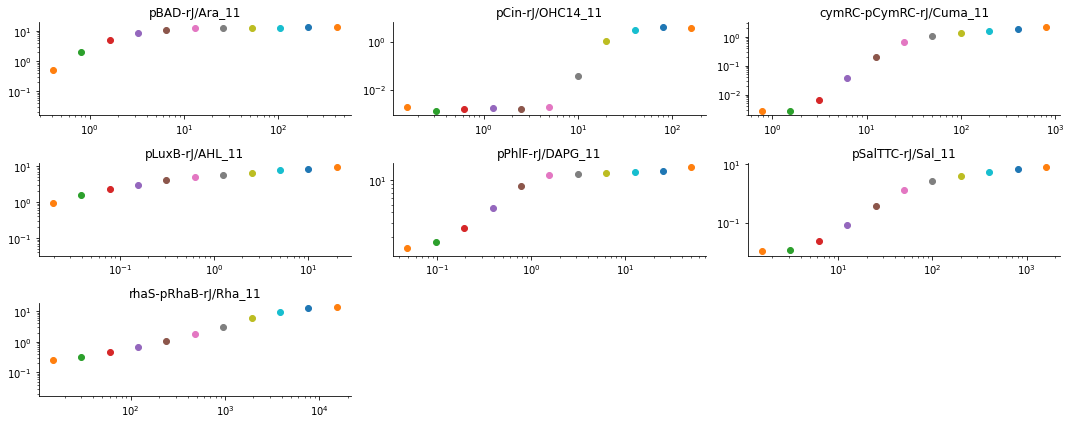

In [30]:
def get_control(fluos, idx):

    gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
    neg_amp = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
    neg_kan = fluos[filter(lambda x: x.startswith('negative-control-kan'), fluos.columns)].mean(axis=1)
    neg_kan_h, gfp_h, neg_amp_h= neg_kan.iloc[idx], gfp.iloc[idx], neg_amp.iloc[idx]
    return neg_kan_h, gfp_h, neg_amp_h

def promoters_plots(row, col, data, inducers, promoters, h=8, sharex=True, sharey=False):
    
    idx = 3 * h
    responses = []
    ctrl = get_control(fluos_2, idx)
    
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*5, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(12):
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - ctrl[0]) / (ctrl[1] - ctrl[2])
                ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 5))
                ax.loglog()
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            responses.append(response)
        else:
            ax.set_visible(False)
    
    sns.despine()
    plt.tight_layout()

promoters_plots(3, 3, fluos_2, inducers, promoters, 10, sharex=False)

#### New promoters characterization

In [77]:
filename = '029-promoters-characterization-06'
map_name = '029-plate_map' #same plate map with experiment 006

promoters = ['pBAD-rJ/Ara', 'araC-pBAD-rJ/Ara', 'cymRC-pCymRC-rJ/Cuma',
             'pLux2-rJ/AHL', 'pPhlF-rJ/DAPG', 'rhaS-pRhaB-rJ/Rha', 'araC-pBAD/Ara']

induction_lvl = 11
max_inducers = [52, 52, 200, 40, 50, 15300, 52] #ara, ohc14, cuma, ahl, dapg, sal, rha
inducers = []
for x, mi in enumerate(max_inducers):
    dil = 4 if x==0 or x==1 or x==3 or x==6 else 2
    inducer = ([mi] + [mi/i for i in [dil**j for j in range(1, induction_lvl+1)]])
    inducer.reverse()
    inducers.append(inducer)

<ipython-input-69-cc6c2a6a502c>:17: RuntimeWarning: invalid value encountered in log
  ax.scatter(np.log(inducers[i]), np.log(response))


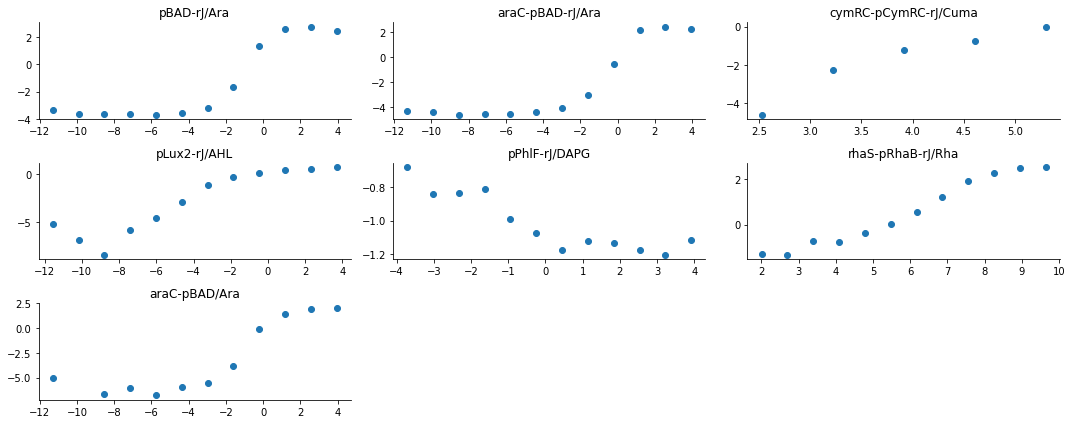

In [78]:
ods, fluos, fluos_1, fluos_2 = read_data(folder, filename, map_name)
df = get_data_at(fluos_2, ods, h=10)
df_res_2, df_ind_2 = generate_responses(df, promoters, inducers)
plot_responses(3, 3, df, inducers, promoters, sharex=False, log_scale=True)

In [ ]:
def get_control(fluos, h=8):

    idx = 3 * h
    gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
    neg_amp = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
    neg_kan = fluos[filter(lambda x: x.startswith('negative-control-kan'), fluos.columns)].mean(axis=1)
    neg_kan_10, gfp_10, neg_amp_10 = neg_kan.iloc[idx], gfp.iloc[idx], neg_amp.iloc[idx]
    return neg_kan_10, gfp_10, neg_amp_10

def promoters_plots(row, col, data, inducers, promoters, ctrl, h=8, sharex=True, sharey=False):
    
    idx = 3 * h
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*5, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(12):
                #if j < 12:
                #    if j%2==1:
                #        continue
                #else:
                #    if j%2==0:
                #        continue
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - ctrl[0]) / (ctrl[1] - ctrl[2])
                ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 5))
                ax.loglog()
                #ax.set_xscale('symlog')
                #ax.set_yscale('symlog')
                #print(promoters[i], j, inducers[i][j])
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            #ax.legend()
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    return responses

In [ ]:
responses = promoters_plots(3, 3, fluos_2, inducers, promoters, get_control(fluos_2, 16), 16, sharex=False)

In [ ]:
df_res = pd.DataFrame(responses).T
df_res.columns = promoters
df_ind = pd.DataFrame(inducers).T
df_ind.columns = promoters

In [ ]:
all_params = []
f, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        y = df_res[promoters[i]]
        x = df_ind[promoters[i]]
        init_guess = [1, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, 0, 0],
                       [1e4, 4, y.min()+0.1, y.max()+0.1]]
        
        popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)
        
        ax.scatter(x, y, color='purple', s=25)
        err = np.round(r2_score(y, hill_activation(x, *popt)), 2)
        #err = np.sum([(a - b)**2 for a, b in zip(y, hill_activation(x, *popt))])
        ax.plot(np.arange(x.max()), hill_activation(np.arange(x.max()), *popt), color='gray', label='R2='+str(err))
        
        all_params.append(popt)
        print(promoters[i], popt, r2_score(y, hill_activation(x, *popt)))
        #ax.loglog()
        #
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        
        ax.set_title('{}'.format(promoters[i]))
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(promoters[i].split('/')[1], u"\u03bcM"))
        ax.legend(loc=4)
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

In [ ]:
all_params

In [ ]:
cumas_gate = [0, 6.25, 12.5, 25, 50, 100]
aras_gate = [0, 0.8125, 3.25, 13, 52, 208]
cumas_rpu = [hill_activation(i, *all_params[2]) for i in cumas_gate]
aras_rpu = [hill_activation(i, *all_params[0]) for i in aras_gate]
print(cumas_rpu)
print(aras_rpu)

In [ ]:
cumas_rpu = [hill_activation(i, *all_params[2]) for i in inducers[2]]
aras_rpu = [hill_activation(i, *all_params[0]) for i in inducers[0]]
print(cumas_rpu)
print(aras_rpu)

In [ ]:
f, axs = plt.subplots(7, 2, sharex=True, sharey=False, figsize=(6, 14))
for i in range(7):
    for j in range(0, 6):
        r0 = fluos['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 0].axvline(8, color='red', linestyle='--')
        axs[i, 0].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(6, 12):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 1].axvline(8, color='red', linestyle='--')
        axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

#### Cherrypicking 3 Promoters Characterization - 24 induction levels

In [ ]:
folder = '011-3-promoters-detailed-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)

In [ ]:
promoters = ['pBAD/Ara', 'pCymRC/Cuma', 'pRhaB/Rha']
aras = [0, 4.95911E-05, 9.91821E-05, 0.000198364, 0.000396729, 0.000793457, 0.001586914, 0.003173828, 0.006347656, 0.012695313, 0.025390625, 0.05078125, 0, 0.1015625, 0.203125, 0.40625, 0.8125, 1.625, 3.25, 6.5, 13, 26, 52, 104]
cumas = [0, 0.001525879, 0.003051758, 0.006103516, 0.012207031, 0.024414063, 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 0, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600, 3200]
rhas = [0, 0.014591217, 0.029182434, 0.058364868, 0.116729736, 0.233459473, 0.466918945, 0.933837891, 1.867675781, 3.735351563, 7.470703125, 14.94140625, 0, 29.8828125, 59.765625, 119.53125, 239.0625, 478.125, 956.25, 1912.5, 3825, 7650, 15300, 30600]
inducers = [aras, cumas, rhas]

In [ ]:
f, axs = plt.subplots(3, 4, sharex=True, sharey=False, figsize=(12, 6))
for i in range(3):
    for j in range(0, 6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--')
        axs[i, 0].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(6, 12):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--')
        axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
    for j in range(12, 18):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 2].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 2].axvline(10, color='red', linestyle='--')
        axs[i, 2].legend()
        axs[i, 2].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 2].set_ylabel('OD')
        axs[i, 2].set_xlabel('Hour')
    for j in range(18, 24):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 3].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 3].axvline(10, color='red', linestyle='--')
        axs[i, 3].legend()
        axs[i, 3].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 3].set_ylabel('OD')
        axs[i, 3].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
def get_control(fluos, h):

    idx = 3 * h
    gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
    neg_amp = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
    neg_kan = fluos[filter(lambda x: x.startswith('negative-control-kan'), fluos.columns)].mean(axis=1)
    neg_kan_10, gfp_10, neg_amp_10 = neg_kan.iloc[idx], gfp.iloc[idx], neg_amp.iloc[idx]
    return neg_kan_10, gfp_10, neg_amp_10

def promoters_plots(row, col, data, inducers, promoters, ctrl, h, sharex=True, sharey=False):
    
    idx = 3 * h
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*5, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(12):
                #if j < 12:
                #    if j%2==1:
                #        continue
                #else:
                #    if j%2==0:
                #        continue
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - ctrl[0]) / (ctrl[1] - ctrl[2])
                ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 5))
                ax.loglog()
                #ax.set_xscale('symlog')
                #ax.set_yscale('symlog')
                #print(promoters[i], j, inducers[i][j])
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            #ax.legend()
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    return responses

In [ ]:
aras_cp = [(4.95911e-05/4), 4.95911e-05, 0.000198364, 0.000793457, 0.003173828, 0.012695313, 0.05078125, 0.203125, 0.8125, 3.25, 13, 52]
rhas_cp = [(0.014591217/4), 0.014591217, 0.058364868, 0.233459473, 0.933837891, 3.735351563, 14.94140625, 59.765625, 239.0625, 956.25, 3825, 15300]
inducers_cp = [aras_cp, rhas_cp]
promoters_cp = ['pBAD/Ara', 'pRhaB/Rha']

In [ ]:
responses = promoters_plots(1, 2, fluos_2, inducers_cp, promoters_cp, get_control(fluos_2, 10), 10, sharex=False)

In [ ]:
responses = promoters_plots(1, 3, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

#### Promoters Characterization - 6 induction levels

In [ ]:
folder = '004-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
fluos_ods = fluos_2 / ods

In [ ]:
aras = [0, 0.8125, 3.25, 13, 52, 208]
ohcs = [0, 0.039, 0.156, 0.625, 2.5, 10]
cumas = [0, 6.25, 12.5, 25, 50, 100]
ahls = [0, 0.039, 0.156, 0.625, 2.5, 10]
dapgs = [0, 0.098, 0.391, 1.563, 6.25, 25]
sals = [0, 0.391, 1.563, 6.25, 25, 100]
rhas = [0, 59.766, 239.063, 956.25, 3825, 15300]
inducers = [aras, ohcs, cumas, ahls, dapgs, sals, rhas]

In [ ]:
idx = 3 * 10
gfp = fluos_2[filter(lambda x: x.startswith('positive-control-amp'), fluos_ods.columns)].mean(axis=1)
neg = fluos_2[filter(lambda x: x.startswith('negative-control-kan'), fluos_ods.columns)].mean(axis=1)
gfp10, neg10 = gfp.iloc[idx], neg.iloc[idx]
gfp10, neg10

In [ ]:
f, axs = plt.subplots(7, 2, sharex=True, sharey=False, figsize=(6, 10))
for i in range(7):
    for j in range(3):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--')
        axs[i, 0].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(3, 6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0, label=j)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--')
        axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
def promoters_plots(row, col, data, promoters, sharex=True, sharey=False):
    
    #xs = np.arange(12)
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(6):
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - neg.iloc[idx]) / (gfp.iloc[idx] - neg.iloc[idx])
                ax.scatter(np.log(inducers[i][j]), np.log(rpu))
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    
    return responses

responses = promoters_plots(2, 4, fluos_2, promoters, sharex=False, sharey=False)

#### Promoters Characterization - 12 induction levels

In [ ]:
def get_control(fluos, h):

    idx = 3 * h
    gfp = fluos[filter(lambda x: x.startswith('positive-control-amp'), fluos.columns)].mean(axis=1)
    neg_amp = fluos[filter(lambda x: x.startswith('negative-control-amp'), fluos.columns)].mean(axis=1)
    neg_kan = fluos[filter(lambda x: x.startswith('negative-control-kan'), fluos.columns)].mean(axis=1)
    neg_kan_10, gfp_10, neg_amp_10 = neg_kan.iloc[idx], gfp.iloc[idx], neg_amp.iloc[idx]
    return neg_kan_10, gfp_10, neg_amp_10

def promoters_plots(row, col, data, inducers, promoters, ctrl, h, sharex=True, sharey=False):
    
    idx = 3 * h
    responses = []
    f, axs = plt.subplots(row, col, sharex=sharex, sharey=sharey, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(promoters):
            response = []
            for j in range(12):
                d = data['{}_{}'.format(promoters[i], j)]
                rpu = (d.iloc[idx] - ctrl[0]) / (ctrl[1] - ctrl[2])
                ax.scatter(inducers[i][j], rpu, label=np.round(inducers[i][j], 2))
                ax.loglog()
                #ax.set_xscale('symlog')
                #ax.set_yscale('symlog')
                response.append(rpu)
            ax.set_title('{}_{}'.format(promoters[i], j))
            #ax.set_xticks(np.arange(12))
            #ax.set_xticklabels([np.round(u, 2) for u in inducers[i]], rotation=45)
            #ax.legend(bbox_to_anchor=(1.1, 1.1))
            responses.append(response)
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
    return responses

In [ ]:
#006
folder = '006-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras = [(0.40625/4), 0.40625, 0.8125, 1.625, 3.25, 6.5, 13, 26, 52, 104, 208, 416]
ohcs = [(0.15625/4), 0.15625, 0.3125, 0.625, 1.25, 2.5, 5, 10, 20, 40, 80, 160]
cumas = [(0.78125/4), 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800]
ahls = [(0.01953125/4), 0.01953125, 0.0390625, 0.078125, 0.15625, 0.3125, 0.625, 1.25, 2.5, 5, 10, 20]
dapgs = [(0.048828125/4), 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50]
sals = [(1.5625/4), 1.5625, 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600]
rhas = [(14.94140625/4), 14.94140625, 29.8828125, 59.765625, 119.53125, 239.0625, 478.125, 956.25, 1912.5, 3825, 7650, 15300]
inducers = [ohcs, cumas, dapgs, sals]
promoters = ['pCin/OHC14', 'pCymRC/Cuma', 'pPhlF/DAPG', 'pSalTTC/Sal']
responses = promoters_plots(1, 4, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [ ]:
df_res1 = pd.DataFrame(responses).T
df_res1.columns = promoters
df_ind1 = pd.DataFrame(inducers).T
df_ind1.columns = promoters

In [ ]:
#010 - AHL & Rha
folder = '010-promoters-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras = [(0.406/8), 0.406, 0.609, 0.813, 1.219, 1.625, 2.438, 3.25, 6.5, 13, 26, 104]
ohcs = [(8/4), 8, 10, 16, 20, 32, 40, 64, 80, 128, 160, 320]
cumas = [(3.125/4), 3.125, 6.25, 12.5, 25, 50, 100, 200, 400, 800, 1600, 3200]
ahls = [(3.81e-5/8), 3.81e-5, 1.53e-4, 6.1e-4, 2.44e-3, 9.77e-3, 3.91e-2, 0.156, 0.625, 2.5, 10, 40]
dapgs = [(0.048828125/4), 0.048828125, 0.09765625, 0.1953125, 0.390625, 0.78125, 1.5625, 3.125, 6.25, 12.5, 25, 50] #does not matter
sals = [(25/4), 25, 50, 100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
rhas = [(29.88/4), 29.88, 59.76, 119.53, 239.06, 478.125, 956.25, 1912.5, 3825, 7650, 15300, 30600]
inducers = [ahls]
promoters = [ 'pLuxB/AHL']
responses = promoters_plots(1, 2, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [ ]:
df_res2 = pd.DataFrame(responses).T
df_res2.columns = promoters
df_ind2 = pd.DataFrame(inducers).T
df_ind2.columns = promoters

In [ ]:
df_res = pd.concat([df_res1, df_res2], axis=1)
df_ind = pd.concat([df_ind1, df_ind2], axis=1)

In [ ]:
#011
folder = '011-3-promoters-detailed-characterization'
fluos, ods, fluos_1, fluos_2 = read_datasets(folder)
aras_cp = [(4.95911e-05/8), 4.95911e-05, 0.000198364, 0.000793457, 0.003173828, 0.012695313, 0.05078125, 0.203125, 0.8125, 3.25, 13, 52]
rhas_cp = [(0.014591217/8), 0.014591217, 0.058364868, 0.233459473, 0.933837891, 3.735351563, 14.94140625, 59.765625, 239.0625, 956.25, 3825, 15300]
inducers = [aras_cp, rhas_cp]
promoters = ['pBAD/Ara', 'pRhaB/Rha']

responses = promoters_plots(1, 2, fluos_2, inducers, promoters, get_control(fluos_2, 10), 10, sharex=False)

In [ ]:
df_res3 = pd.DataFrame(responses).T
df_res3.columns = promoters
df_ind3 = pd.DataFrame(inducers).T
df_ind3.columns = promoters

In [ ]:
df_res = pd.concat([df_res, df_res3], axis=1)
df_ind = pd.concat([df_ind, df_ind3], axis=1)

In [ ]:
def promoters_combined_plots(row, col, data, inducers):
    
    cols = ['pBAD/Ara', 'pCin/OHC14', 'pCymRC/Cuma', 'pLuxB/AHL', 'pPhlF/DAPG', 'pSalTTC/Sal', 'pRhaB/Rha']
    #ind_names = ['OHC14', 'Cuma', 'DAPG', 'Sal', 'AHL', 'Ara', 'Rha']
    #cols = data.columns.tolist()
    f, axs = plt.subplots(row, col, sharex=False, sharey=False, figsize=(col*3, row*2))
    axr = axs.ravel()
    for i, ax in enumerate(axr):
        if i < len(cols):
            for x, y in zip(inducers[cols[i]], data[cols[i]]):
                ax.scatter(x, y)
                ax.loglog()
            ax.set_title('{}'.format(cols[i]))
            ax.set_ylabel('RPU')
            ax.set_xlabel('{} ({})'.format(cols[i].split('/')[1], u"\u03bcM"))
        else:
            ax.set_visible(False)
    sns.despine()
    plt.tight_layout()
                         
promoters_combined_plots(2, 4, df_res, df_ind)

In [ ]:
df_res.to_csv('datasets/experiment/responses.csv', index=False)
df_ind.to_csv('datasets/experiment/inducers.csv', index=False)

#### Response Function

In [ ]:
promoters = ['pBAD/Ara', 'pCin/OHC14', 'pCymRC/Cuma', 'pLuxB/AHL', 'pPhlF/DAPG', 'pSalTTC/Sal', 'pRhaB/Rha']
responses = pd.read_csv('datasets/experiment/responses.csv')
inducers = pd.read_csv('datasets/experiment/inducers.csv')

In [ ]:
for i in range(responses.shape[1]):
    responses.iloc[:,i] = (responses.iloc[:,i] - responses.iloc[:,i].min())
responses

In [ ]:
np.round(responses[['pBAD/Ara', 'pCymRC/Cuma']].T, 2)

In [ ]:
all_params = []
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        y = responses[promoters[i]]
        x = np.arange(1, len(y)+1)
        #x = inducers[promoters[i]]
        init_guess = [1, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, y.min()-1, y.max()-1],
                       [1e4, 10, y.min()+1, y.max()+1]]
        
        popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)
        
        ax.scatter(x, y, color='purple', s=25)
        err = np.round(r2_score(y, hill_activation(x, *popt)), 2)
        #err = np.sum([(a - b)**2 for a, b in zip(y, hill_activation(x, *popt))])
        ax.plot(np.arange(0, x.max()+2, 0.5), hill_activation(np.arange(0, x.max()+2, 0.5), *popt), color='gray', label='R2=' + str(err))
        
        all_params.append(popt)
        print(promoters[i], popt, r2_score(y, hill_activation(x, *popt)))
        #ax.loglog()
        #ax.set_xscale('symlog')
        #ax.set_yscale('symlog')
        #ax.set_xticks(np.arange(len(inducers[promoters[i]])))
        #ax.set_xticklabels(None)
        
        ax.set_title('{}'.format(promoters[i]))
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(promoters[i].split('/')[1], u"\u03bcM"))
        ax.legend(loc=4)
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

In [ ]:
all_params = []
f, axs = plt.subplots(2, 4, sharex=False, sharey=False, figsize=(12, 5))
axr = axs.ravel()
for i, ax in enumerate(axr):
    if i < len(promoters):
        y = responses[promoters[i]]
        x = inducers[promoters[i]]
        init_guess = [1, 1, y.min(), y.max()]
        gate_bounds = [[0, 0, 0, 0],
                       [1e4, 4, y.min()+0.1, y.max()+0.1]]
        
        popt, pcov = curve_fit(hill_activation, x, y, p0=init_guess, bounds=gate_bounds)
        
        ax.scatter(x, y, color='purple', s=25)
        err = np.round(r2_score(y, hill_activation(x, *popt)), 2)
        #err = np.sum([(a - b)**2 for a, b in zip(y, hill_activation(x, *popt))])
        ax.plot(np.arange(x.max()), hill_activation(np.arange(x.max()), *popt), color='gray', label='R2='+str(err))
        
        all_params.append(popt)
        print(promoters[i], popt, r2_score(y, hill_activation(x, *popt)))
        #ax.loglog()
        #ax.set_xscale('symlog')
        #ax.set_yscale('symlog')
        
        ax.set_title('{}'.format(promoters[i]))
        ax.set_ylabel('RPU')
        ax.set_xlabel('{} ({})'.format(promoters[i].split('/')[1], u"\u03bcM"))
        ax.legend(loc=4)
    else:
        ax.set_visible(False)
    sns.despine()
plt.tight_layout()

In [ ]:
inducers

In [ ]:
for j, c in enumerate(promoters):
    print('"', c.split('/')[1].lower(), '_rpu":', [hill_activation(i, *all_params[j]) for i in inducers[c]])

In [ ]:
#cumas_gate = [0, 6.25, 12.5, 25, 50, 100]
#aras_gate = [0, 0.8125, 3.25, 13, 52, 208]
cumas_gate = [0, 6.25, 12.5, 25, 50, 100]
aras_gate = [0, 0.8125, 1.625, 3.25, 6.5, 13]
cumas_rpu = [hill_activation(i, *all_params[2]) for i in cumas_gate]
aras_rpu = [hill_activation(i, *all_params[0]) for i in aras_gate]
print(cumas_rpu)
print(aras_rpu)

Data Inspections

In [ ]:
f, axs = plt.subplots(7, 2, sharex=False, sharey=False, figsize=(6, 10))
for i in range(7):
    for j in range(5, 6):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 0].plot(r0.index/60, r0)#, color='darkblue')
        axs[i, 0].axvline(10, color='red', linestyle='--', label='10h')
        #axs[i, 1].legend()
        axs[i, 0].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 0].set_ylabel('OD')
        axs[i, 0].set_xlabel('Hour')
    for j in range(6, 12):
        r0 = ods['{}_{}'.format(promoters[i], j)]
        axs[i, 1].plot(r0.index/60, r0)#, color='darkblue')
        axs[i, 1].axvline(10, color='red', linestyle='--', label='10h')
        #axs[i, 1].legend()
        axs[i, 1].set_title('{}_{}'.format(promoters[i], j))
        axs[i, 1].set_ylabel('OD')
        axs[i, 1].set_xlabel('Hour')
sns.despine()
plt.tight_layout()

In [ ]:
f, axs = plt.subplots(7, 12, sharex=True, sharey=True, figsize=(20, 10))
for i in range(7):
    for j in range(12):
        r0 = fluos_2['{}_{}'.format(promoters[i], j)]
        axs[i, j].plot(r0.index/60, r0, color='darkblue')
        axs[i, j].axvline(10, color='red', linestyle='--', label='10h')
        axs[i, j].legend()
        axs[i, j].set_title('{}_{}'.format(promoters[i], j))
        axs[i, j].set_ylabel('Fluo (a.u.)')
        axs[i, j].set_xlabel('Hour')
sns.despine()
plt.tight_layout()